In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data/'
test_dir = data_dir + 'images/test/'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = ImageFolder(test_dir, transform=transform, target_transform=None)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

In [3]:
model = torch.load('../models/ResNet50_pretrained-epoch94-batch_size32-lr0.01-loss0.0440.pt')
model.eval()
device = next(model.parameters()).device.type

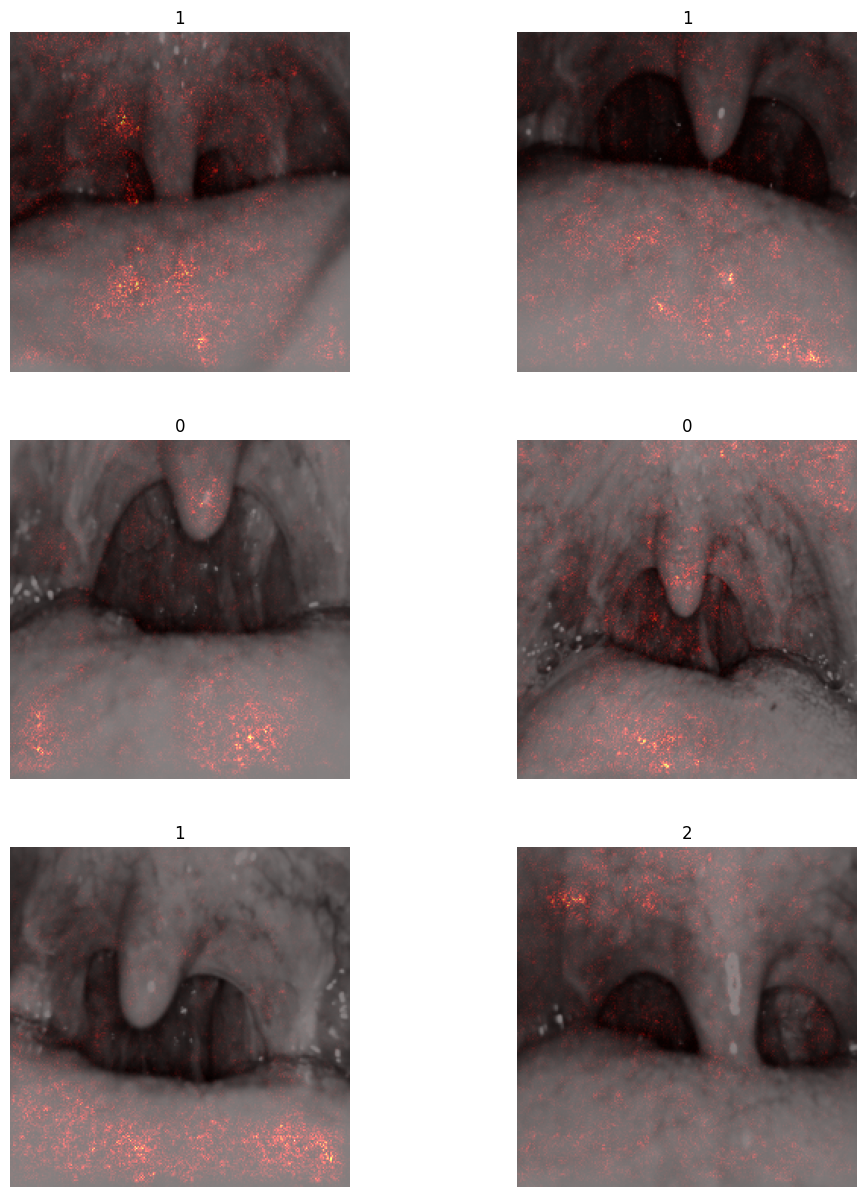

In [5]:
num_plots = 6
num_rows = (num_plots + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
for idx in range(num_plots):
    images, labels = next(iter(test_loader))
    input_batch = images
    input_batch = input_batch.to(device)
    input_batch.requires_grad_()

    output = model(input_batch)
    output_idx = output.argmax()
    output[0, output_idx].backward()

    saliency_map = np.resize(input_batch.grad.data.abs().squeeze()[0].cpu().numpy(), (input_batch.shape[2], input_batch.shape[3]))

    image = input_batch.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    grey_img = np.dot(image[..., :3], [0.299, 0.587, 0.114])

    axes[idx // 2, idx % 2].imshow(grey_img, cmap='gray')
    axes[idx // 2, idx % 2].imshow(saliency_map, cmap='hot', alpha=0.5)
    axes[idx // 2, idx % 2].axis('off')
    axes[idx // 2, idx % 2].set_title(labels.numpy()[0])
plt.show()